# Week 1 — BloodMNIST Veri Keşfi (EDA)
Bu notebook, BloodMNIST veri setini indirip inceler.
Amacımız veri yapısını, sınıf dağılımını ve temel istatistikleri anlamaktır.

In [7]:
# Kütüphaneler
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
from medmnist import INFO, BloodMNIST
from torchvision import transforms

In [8]:
import torch
from medmnist import INFO, BloodMNIST
from torchvision import transforms

# Dönüşüm tanımla
data_transform = transforms.Compose([
    transforms.ToTensor()
])

# Veri seti bilgileri
info = INFO["bloodmnist"]
print(f"Veri Seti: {info['description']}")

# Eğitim ve test veri setlerini yükle
train_dataset = BloodMNIST(split='train', transform=data_transform, download=True)
test_dataset = BloodMNIST(split='test', transform=data_transform, download=True)

print(f"Eğitim veri sayısı: {len(train_dataset)}")
print(f"Test veri sayısı: {len(test_dataset)}")


Veri Seti: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
Eğitim veri sayısı: 11959
Test veri sayısı: 3421


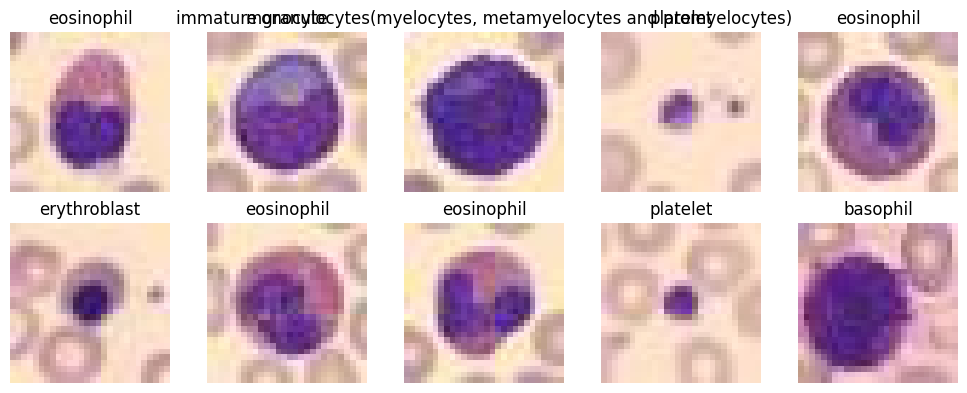

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Rastgele 10 örnek seç
random.seed()
sample_indices = random.sample(range(len(train_dataset)), 10)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()  # 2D yerine tek boyutlu yap

for i, idx in enumerate(sample_indices):
    img, label = train_dataset[idx]
    ax = axes[i]
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    try:
        ax.set_title(info['label'][str(label.item())])
    except:
        ax.set_title(f"Label: {label.item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import random
import pandas as pd
import numpy as np
import cv2
from skimage.measure import regionprops, label as sk_label
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops

# Özellik çıkarım fonksiyonu
def extract_features(img_tensor):
    img = np.transpose(img_tensor.numpy(), (1, 2, 0))
    gray = rgb2gray(img)

    # Basit maske oluşturma
    mask = (gray < 0.8).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((2, 2), np.uint8))

    # Bölge özellikleri
    lbl = sk_label(mask)
    regions = regionprops(lbl)
    if len(regions) == 0:
        return None

    region = max(regions, key=lambda r: r.area)

    # GLCM (texture) özellikleri
    glcm = graycomatrix((gray * 255).astype(np.uint8), [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    return {
        "area": region.area,
        "eccentricity": region.eccentricity,
        "solidity": region.solidity,
        "contrast": contrast,
        "homogeneity": homogeneity
    }

# -----------------------------
# 🔹 Rastgele veri örnekleme
# -----------------------------
random.seed()
sample_indices = random.sample(range(len(train_dataset)), 500)  # 500 örnek seçelim

features_list = []

for idx in sample_indices:
    img, label = train_dataset[idx]
    f = extract_features(img)
    if f is not None:
        f["label"] = int(label)
        features_list.append(f)

# Özellikleri DataFrame’e dönüştür
df_features = pd.DataFrame(features_list)
print("✅ Özellik çıkarımı tamamlandı.")
print(df_features.head())


✅ Özellik çıkarımı tamamlandı.
    area  eccentricity  solidity    contrast  homogeneity  label
0  598.0      0.668980  0.864162  533.973545     0.118704      5
1  391.0      0.771953  0.837259  520.904762     0.148980      6
2  630.0      0.331352  0.816062  459.509259     0.078223      5
3  413.0      0.497764  0.858628  541.079365     0.112607      1
4  329.0      0.405223  0.956395  531.461640     0.106129      6


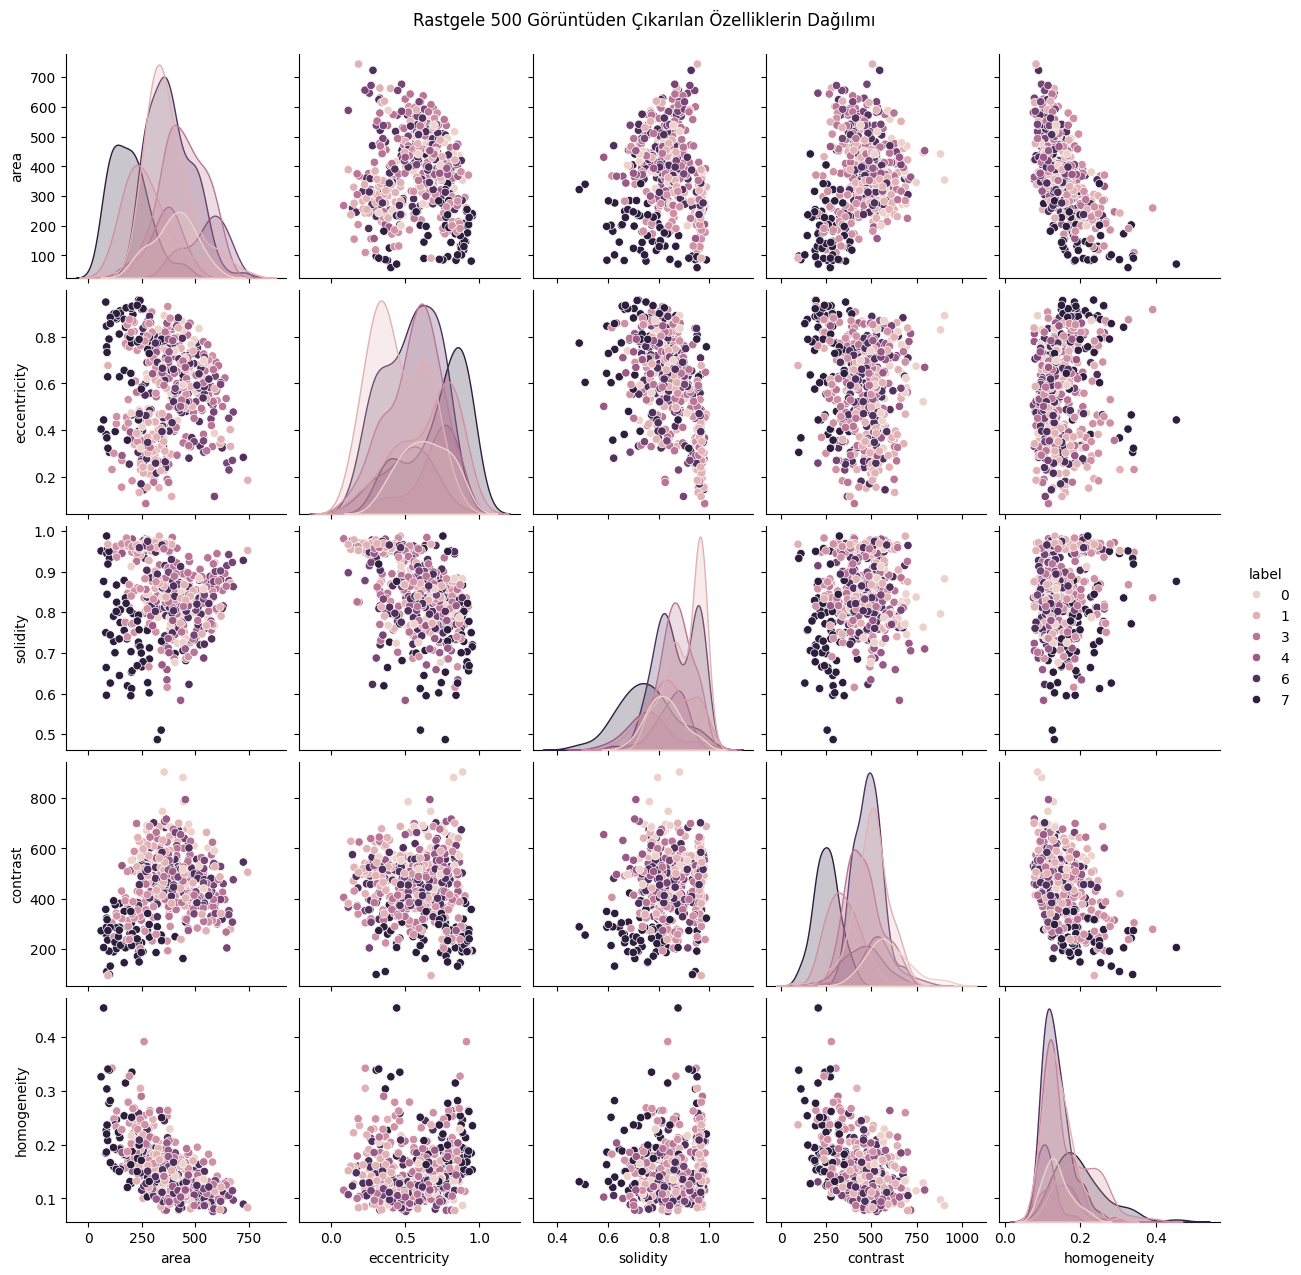

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_features, hue="label", diag_kind="kde")
plt.suptitle("Rastgele 500 Görüntüden Çıkarılan Özelliklerin Dağılımı", y=1.02)
plt.show()


In [12]:
import os

# Eğer "data" klasörü yoksa oluştur
os.makedirs("data", exist_ok=True)

# Dosyayı kaydet
df_features.to_csv("data/features_week1.csv", index=False)
print("✅ Özellikler 'data/features_week1.csv' olarak kaydedildi.")

✅ Özellikler 'data/features_week1.csv' olarak kaydedildi.


## Gözlemler:
- Veri setinde **8 sınıf** var (örnek: eosinophil, neutrophil vs.).
- Sınıf dağılımı dengeli / dengesiz mi? (Grafiğe bak.)
- Görseller 28x28 RGB formatında, renk kontrastı düşük.
- Ortalama renk kan hücrelerinin kırmızımsı tonunu yansıtıyor.